In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
# Merge our DFT result data with the Kraken ML data for the ligands.
dft_df = pd.read_csv("dft_data/lambda_max_v_bond_len_H_only.csv")
kraken_df = pd.read_csv("kraken_data/ml_8_210.csv")

merged_df = pd.merge(dft_df, kraken_df, on="molecule_id")
merged_df.head()
# Effectively, I think of this as a left joining kraken_df on dft_df

molecule_id  lambda_max  shift  Pd-H_length  \
0            8       395.4    0.0      2.30055   
1           12       421.5   26.1      2.59931   
2         1648       378.0  -17.4      1.94427   
3         1656       414.7   19.3      2.29422   
4        16511       369.7  -25.7      2.05612   

                                 smiles  dipolemoment_max  pyr_P_max  \
0           CC(C)(C)P(C(C)(C)C)C(C)(C)C          0.785410   0.814829   
1          CC(C)(C)CP(C(C)(C)C)C(C)(C)C          0.819760   0.883014   
2     CC(C)(C)P(c1cccc2ccccc12)C(C)(C)C          0.943379   0.852600   
3  Cc1cc(C)c(P(C(C)(C)C)C(C)(C)C)c(C)c1          1.063524   0.785253   
4     CCC#CC(C)(C)P(CC(C)(C)C)CC(C)(C)C          0.828542   0.937721   

   pyr_alpha_max  qpole_amp_max  qpoletens_xx_max  ...  \
0      32.633045       2.286466          1.155208  ...   
1      28.707630       1.997507          0.856250  ...   
2      30.313591       5.221972          3.356086  ...   
3      33.952614       4.349228          2.703184  ...   
4      21.047157       4.292618          3.905047  ...   

   vbur_qvbur_max_boltzmann_average  vbur_qvbur_min_boltzmann_average  \
0                         20.849024                         14.705131   
1                         21.402498                         14.062596   
2                         27.215685                         14.099444   
3                         27.946302                         15.067517   
4                         19.559307                         15.134177   

   vbur_qvtot_max_boltzmann_average  vbur_qvtot_min_boltzmann_average  \
0                         92.370575                         50.689070   
1                         89.652150                         54.039700   
2                        146.207050                         46.511883   
3                        128.196730                         51.288940   
4                         95.923110                         64.802795   

   vbur_ratio_vbur_vtot_boltzmann_average  vbur_vbur_boltzmann_average  \
0                                0.277816                    72.062120   
1                                0.271465                    74.782196   
2                                0.235295                    75.336480   
3                                0.252914                    80.446860   
4                                0.236930                    76.982850   

   vbur_vtot_boltzmann_average  vmin_r_boltzmann_average  \
0                    253.71219                  1.756687   
1                    271.61676                  1.767097   
2                    322.30103                  1.779128   
3                    320.88870                  1.754941   
4                    338.08795                  1.775052   

   vmin_vmin_boltzmann_average  volume_boltzmann_average  
0                    -0.069888                 320.95413  
1                    -0.064135                 345.01490  
2                    -0.060278                 385.63310  
3                    -0.062705                 392.55540  
4                    -0.056829                 424.17822  

[5 rows x 195 columns]

In [3]:
# Let's start with the top 20 features in the first principal component from our PCA (see ligand_pca.ipynb)
# Then let's examine their multicollinearity and remove features until we have significantly reduced that.
# We can also use various algorithms to do feature selection for us at this point.

# Since these data are all related to complexes with some agostic interaction, I have decided to include the distance between
# Pd and H (Pd-H_length) to see if the model hones in on this feature and whether that is generally helpful to us.

first_pca_20_and_Pd_H_length = [
    "Pd-H_length",
    # "nbo_lp_P_percent_s_boltzmann_average",
    # "nbo_lp_P_occ_boltzmann_average",
    # "nmrtens_sxx_P_boltzmann_average",
    # "vmin_r_boltzmann_average",
    # "nmr_P_boltzmann_average",
    # "vbur_max_delta_qvtot_max",
    # "vbur_max_delta_qvtot_vburminconf",
    # "vbur_ratio_vbur_vtot_boltzmann_average",
    # "vbur_max_delta_qvtot_boltzmann_average",
    # "vbur_max_delta_qvtot_min",
    # "sterimol_burB5_boltzmann_average",
    # "vbur_ovbur_max_max",
    # "vbur_qvbur_max_max",
    # "vbur_ovbur_max_vburminconf",
    # "vbur_ovbur_max_boltzmann_average",
    # "vbur_qvbur_max_boltzmann_average",
    # "vbur_ovbur_max_min",
    # "vbur_qvbur_max_min",
    "vbur_far_vtot_max"
]
features = merged_df[first_pca_20_and_Pd_H_length]

# plt.figure(figsize= (20, 20))
# corr_heatmap = sns.heatmap(features.corr(), annot=True)

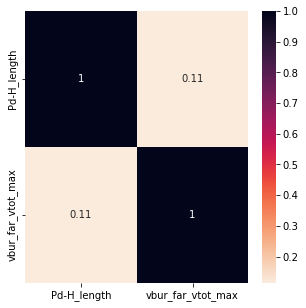

In [4]:
# Let's do an absolute heatmap (and set the color axis so that 0 is light, 1 is dark):
plt.figure(figsize= (5, 5))
cmap = sns.cm.rocket_r
abs_corr_heatmap = sns.heatmap(abs(features.corr()), annot=True, cmap=cmap)

In [5]:
# Set the feature and target values:
X = features.values
target = merged_df.columns[1]
y = merged_df[target].values

In [6]:
print(sklearn.metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'd2_absolute_error_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'r

In [7]:
# Leave-one-out CV
from sklearn.model_selection import LeaveOneOut
def loocv(X, y, model, verbose=False):
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    
    y_preds = []
    for i, (train_indices, test_index) in enumerate(loo.split(X)):
        print(f"Fold {i}: ", end="")
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_preds.append(y_pred[0])
        print("complete.  ", end="")
        
        if verbose:
            print()
            print(model.coef_)
            print(model.intercept_)
    
    print()
    return y_preds

In [8]:
y_preds = loocv(X, y, LinearRegression(), verbose=True)
print(y_preds)

Fold 0: complete.  
[76.74101163  0.69912899]
208.60566328630253
Fold 1: complete.  
[74.44188035  0.69804602]
213.7531081836432
Fold 2: complete.  
[79.74852633  0.68777548]
201.85264208959396
Fold 3: complete.  
[76.21361616  0.67801784]
209.77291230068704
Fold 4: complete.  
[75.93354279  0.67758244]
210.96679819783213
Fold 5: complete.  
[78.18525297  0.70435223]
205.1846332203797
Fold 6: complete.  
[78.35463752  0.69257442]
204.90596158743048
Fold 7: complete.  
[77.60076131  0.72512647]
206.67673172689067
Fold 8: complete.  
[76.37598435  0.68235602]
209.7357187692153
Fold 9: complete.  
[76.06470529  0.73873751]
209.30484211986212
Fold 10: complete.  
[76.70385205  0.68885029]
208.92340575784826
Fold 11: complete.  
[74.24195289  0.63959008]
215.55085188135806
Fold 12: complete.  
[75.88870585  0.7040255 ]
210.3682757325152
Fold 13: complete.  
[76.81459279  0.70800939]
208.50542038200774
Fold 14: complete.  
[77.10934504  0.69476471]
207.98979359795314
Fold 15: complete.  
[76

In [28]:
# Compute MSE:
squared_errors = []
for i in range(len(y_preds)):
    squared_errors.append(round((y_preds[i] - y[i]) ** 2, 1))
    print(f"{dft_df.iloc[i]["molecule_id"]} SE: {round((y_preds[i] - y[i]) ** 2, 1)}")
print(f"LOOCV MSE: {round((sum(squared_errors) / len(squared_errors)), 1)}")

8.0 SE: 0.1
12.0 SE: 21.6
1648.0 SE: 88.5
1656.0 SE: 398.2
16511.0 SE: 76.8
16670.0 SE: 10.6
16848.0 SE: 95.6
19864.0 SE: 49.2
19867.0 SE: 43.5
19874.0 SE: 50.0
19877.0 SE: 0.4
19880.0 SE: 364.6
19884.0 SE: 21.3
19898.0 SE: 35.0
19901.0 SE: 28.1
19903.0 SE: 187.9
19904.0 SE: 64.2
19905.0 SE: 84.7
19929.0 SE: 363.8
19937.0 SE: 21.3
19939.0 SE: 2.0
19961.0 SE: 57.4
19966.0 SE: 110.1
19973.0 SE: 0.2
19985.0 SE: 1.6
149979.0 SE: 24.4
182739.0 SE: 0.1
182768.0 SE: 73.3
182847.0 SE: 1342.5
183055.0 SE: 932.4
20079.0 SE: 43.2
20094.0 SE: 139.3
20097.0 SE: 1763.4
20103.0 SE: 511.5
20107.0 SE: 1.3
20113.0 SE: 0.8
20130.0 SE: 250.4
20137.0 SE: 3.7
20140.0 SE: 19.3
20153.0 SE: 1.4
20154.0 SE: 4.0
20220.0 SE: 352.8
LOOCV MSE: 181.9


In [10]:
linear_2feature = LinearRegression()
linear_2feature.fit(X, y)
print(f"Linear, 2-feature coefficients: {linear_2feature.coef_}")
print(f"Linear, 2-feature R2: {linear_2feature.score(X, y)}")

Linear, 2-feature coefficients: [76.83600424  0.68765939]
Linear, 2-feature R2: 0.534337187403976


<Axes: xlabel='molecule_id'>

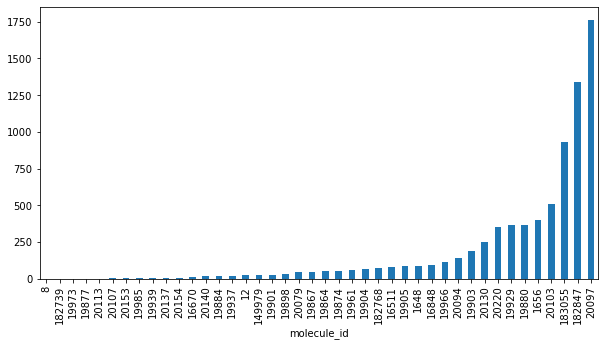

In [24]:
pd.Series(squared_errors, dft_df["molecule_id"]).sort_values(ascending = True).plot(kind = "bar", figsize=(10,5))
# TODO: double check that the labels and the names are correctly corresponding
# same with the other such plots too

In [18]:
# Some of the worst-predicted ligands are 20097, 182847, and 183055, which all feature an aryl methyl "straddling" the metal center.
# I'm not really sure about this, but it might be possible that the agostic is stronger than one might predict
# if there is some interaction between both Hs and Pd maybe, but the model really effectively only accounts for one.
# On the other hand, numerous other "methyl straddles" are well-predicted, like 20140 and 182739.
# So I'm not sure, it might be a coincidence, or there may be some other factor that leads to these ligands being poorly predicted.
# Perhaps, also, the very symmetrical methyl straddles are poorly predicted, while e.g. 20140 and 182739 actually are not really symmetric
# so those ones are closer to "traditional" agostic interactions
# I guess I should look a little into agostic interactions, I'm sure this has been studied and observed before. 
# I think this is seen for those solid-state generated agostics, which were Ir I think, what was that paper?

# Badly-predicted:
# 182847 Pd-H distances: 2.29005, 2.24364  diff: ~0.05
# 183055 Pd-H distances: 2.29815, 2.24564  diff: ~0.05
# 20097 Pd-H distances: 2.33343, 2.06998  diff: ~0.26
# 20097 is still an outlier, but there seems to be something to the general trend

# Meh
# 20103 Pd-H distances: 2.3202, 2.08786  diff: ~0.23

# Well-predicted:
# 182739 Pd-H distances: 2.52356, 2.13152  diff: ~0.39
# 182768 Pd-H distances: 2.51897, 2.139  diff: ~0.38
# 20140 Pd-H distances: 2.49074, 2.10685  diff: ~0.38
# well it is more...

<Figure size 432x288 with 0 Axes>

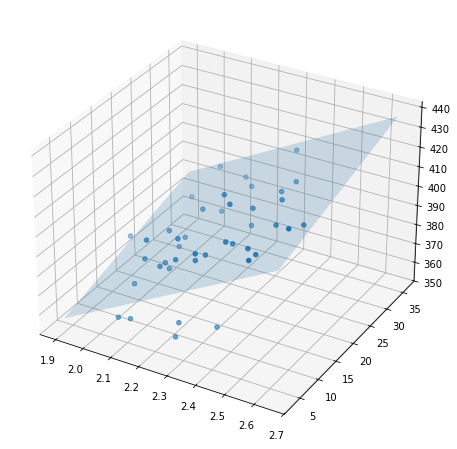

In [12]:
# Plot the plane in 3D:
from mpl_toolkits import mplot3d

fig = plt.figure()
plt.figure(figsize= (8, 8))

ax = plt.axes(projection='3d')
ax.scatter3D(X.T[0], X.T[1], y)

x1_coef, x2_coef, intercept = linear_2feature.coef_[0], linear_2feature.coef_[1], linear_2feature.intercept_
x1lim, x2lim = ax.get_xlim(), ax.get_ylim()
x1, x2 = np.meshgrid(
    np.linspace(x1lim[0], x1lim[1], 10),
    np.linspace(x2lim[0], x2lim[1], 10)
)
y_plane = x1_coef*x1 + x2_coef*x2 + intercept
surf = ax.plot_surface(x1, x2, y_plane, alpha=0.2)

In [13]:
# Boostrap CV
from sklearn.utils import resample

boot = resample(X, replace=True, n_samples=len(X), random_state=1)
# print(boot)

In [14]:
# Also, how much better is out model than a 1-parameter regression with Pd-H length?
# for what that model would lack in flexibility it may just fare well due to not overfitting...
# basically, does the Kraken ML data really add anything or not, is it actually learning from that stuff
from sklearn.linear_model import LinearRegression
import numpy as np

linear_agostic = LinearRegression()
X_PdH = merged_df.loc[:, ["Pd-H_length"]].to_numpy()
linear_agostic.fit(X_PdH, y)

print(f"Linear, agostic R2: {linear_agostic.score(X_PdH, y)}")

Linear, agostic R2: 0.43581010687840327


In [15]:
y_preds = loocv(X_PdH, y, linear_agostic)
print(y_preds)

Fold 0: complete.  Fold 1: complete.  Fold 2: complete.  Fold 3: complete.  Fold 4: complete.  Fold 5: complete.  Fold 6: complete.  Fold 7: complete.  Fold 8: complete.  Fold 9: complete.  Fold 10: complete.  Fold 11: complete.  Fold 12: complete.  Fold 13: complete.  Fold 14: complete.  Fold 15: complete.  Fold 16: complete.  Fold 17: complete.  Fold 18: complete.  Fold 19: complete.  Fold 20: complete.  Fold 21: complete.  Fold 22: complete.  Fold 23: complete.  Fold 24: complete.  Fold 25: complete.  Fold 26: complete.  Fold 27: complete.  Fold 28: complete.  Fold 29: complete.  Fold 30: complete.  Fold 31: complete.  Fold 32: complete.  Fold 33: complete.  Fold 34: complete.  Fold 35: complete.  Fold 36: complete.  Fold 37: complete.  Fold 38: complete.  Fold 39: complete.  Fold 40: complete.  Fold 41: complete.  
[395.70730349717576, 416.8483092529236, 368.59095018035464, 394.7449763226889, 378.4638746841119, 380.34391035566284, 382.02494279364294, 396.41327134628216, 406.1033194

In [16]:
squared_errors = []
for i in range(len(y_preds)):
    squared_errors.append(round((y_preds[i] - y[i]) ** 2, 1))
print(f"LOOCV MSE: {round((sum(squared_errors) / len(squared_errors)), 1)}")

LOOCV MSE: 181.9


In [17]:
# AAAAAAAAAAAGGGGGGGGGGGGGGGGHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
# The simple model MSE is MUCH lower than our "optimized" elastic net.
# So clearly we are overfitting then.